# Plot the cloud coverage 

In [1]:
import hikinggc
from importlib import reload
reload(hikinggc)

import os
import geojson
import rasterio
import json
import numpy as np
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.gridliner as gridliner

import logging
import cmocean
from matplotlib.colors import LightSource
import matplotlib as mpl
mpl.style.use("./hiking.mplstyle")
coast = cartopy.feature.GSHHSFeature(scale='f')

<frozen importlib._bootstrap>:219: UserWarning: PROJ 8+ is required. Current version: 7.2.1


## Files and directories

In [10]:
coastfile1 = os.path.join(hikinggc.datadir, "ProvinciaLasPalmas.geojson")
coastfile2 = os.path.join(hikinggc.datadir, "ProvinciaSantaCruz.geojson")
datafile = os.path.join(hikinggc.datadir, "Rain/MODAL2_M_CLD_FR_2021-07-01_rgb_3600x1800.TIFF")
datafile2 = os.path.join(hikinggc.datadir, "MODCF_meanannual.tif")
cloudfile = "/data/CloudCoverage/MODCF_monthlymean_07.tif"
topofile = os.path.join(hikinggc.datadir, '136_MDT25_GC/136_MDT25_GC.tif')
topofile2 = os.path.join(hikinggc.datadir, 'DTM Spain_Canary Islands 50m v2 by Sonny.tif')
municipiosfile = os.path.join(hikinggc.datadir, "MunicipiosGC.geojson")

IC = hikinggc.Island(hikinggc.iccoords)
GC = hikinggc.Island(hikinggc.gccoords)

## Read data
### Municipios

In [4]:
with open(municipiosfile, "r") as f:
    datamun = json.load(f)

### Topography

In [8]:
topography = hikinggc.Topography()
topography.read_geotiff_domain(topofile)
topography.image = np.ma.masked_less_equal(topography.image, 0.)

topography2 = hikinggc.Topography()
topography2.read_geotiff_domain(topofile2)
topography2.image = np.ma.masked_less_equal(topography2.image, 0.)

### Cloud coverage

In [9]:
cloud = hikinggc.Topography()
cloud.read_geotiff_domain(cloudfile, hikinggc.iccoords)

RasterioIOError: /data/CloudCoverage/MODCF_monthlymean_07.tif: No such file or directory

### Hillshade

In [4]:
cmap = plt.cm.gray
ls = LightSource(azdeg=315, altdeg=45)
dx, dy = 25., 25. # resolution in meters
ve = 10.
rgb = ls.shade(topography.image, cmap=cmap, blend_mode='overlay', vert_exag=ve, dx=dx, dy=dy)
rgb2 = ls.shade(topography2.image, cmap=cmap, blend_mode='overlay', vert_exag=ve, dx=2*dx, dy=2*dy)
hs2 = ls.hillshade(topography2.image, vert_exag=ve, dx=2*dx, dy=2*dy)

In [5]:
# Mask 
cloud.image = np.ma.masked_greater(cloud.image, 20000., copy=True)

In [9]:
with rasterio.open(topofile2) as dataset:

   # you can see the affine transformation matrix (that you had above) like this:
   print(dataset.read_crs())
#proj2 = ccrs.epsg("3040")
#proj2

EPSG:3040


ParseError: not well-formed (invalid token): line 1, column 0 (<string>)

## Make plot
### All the islands

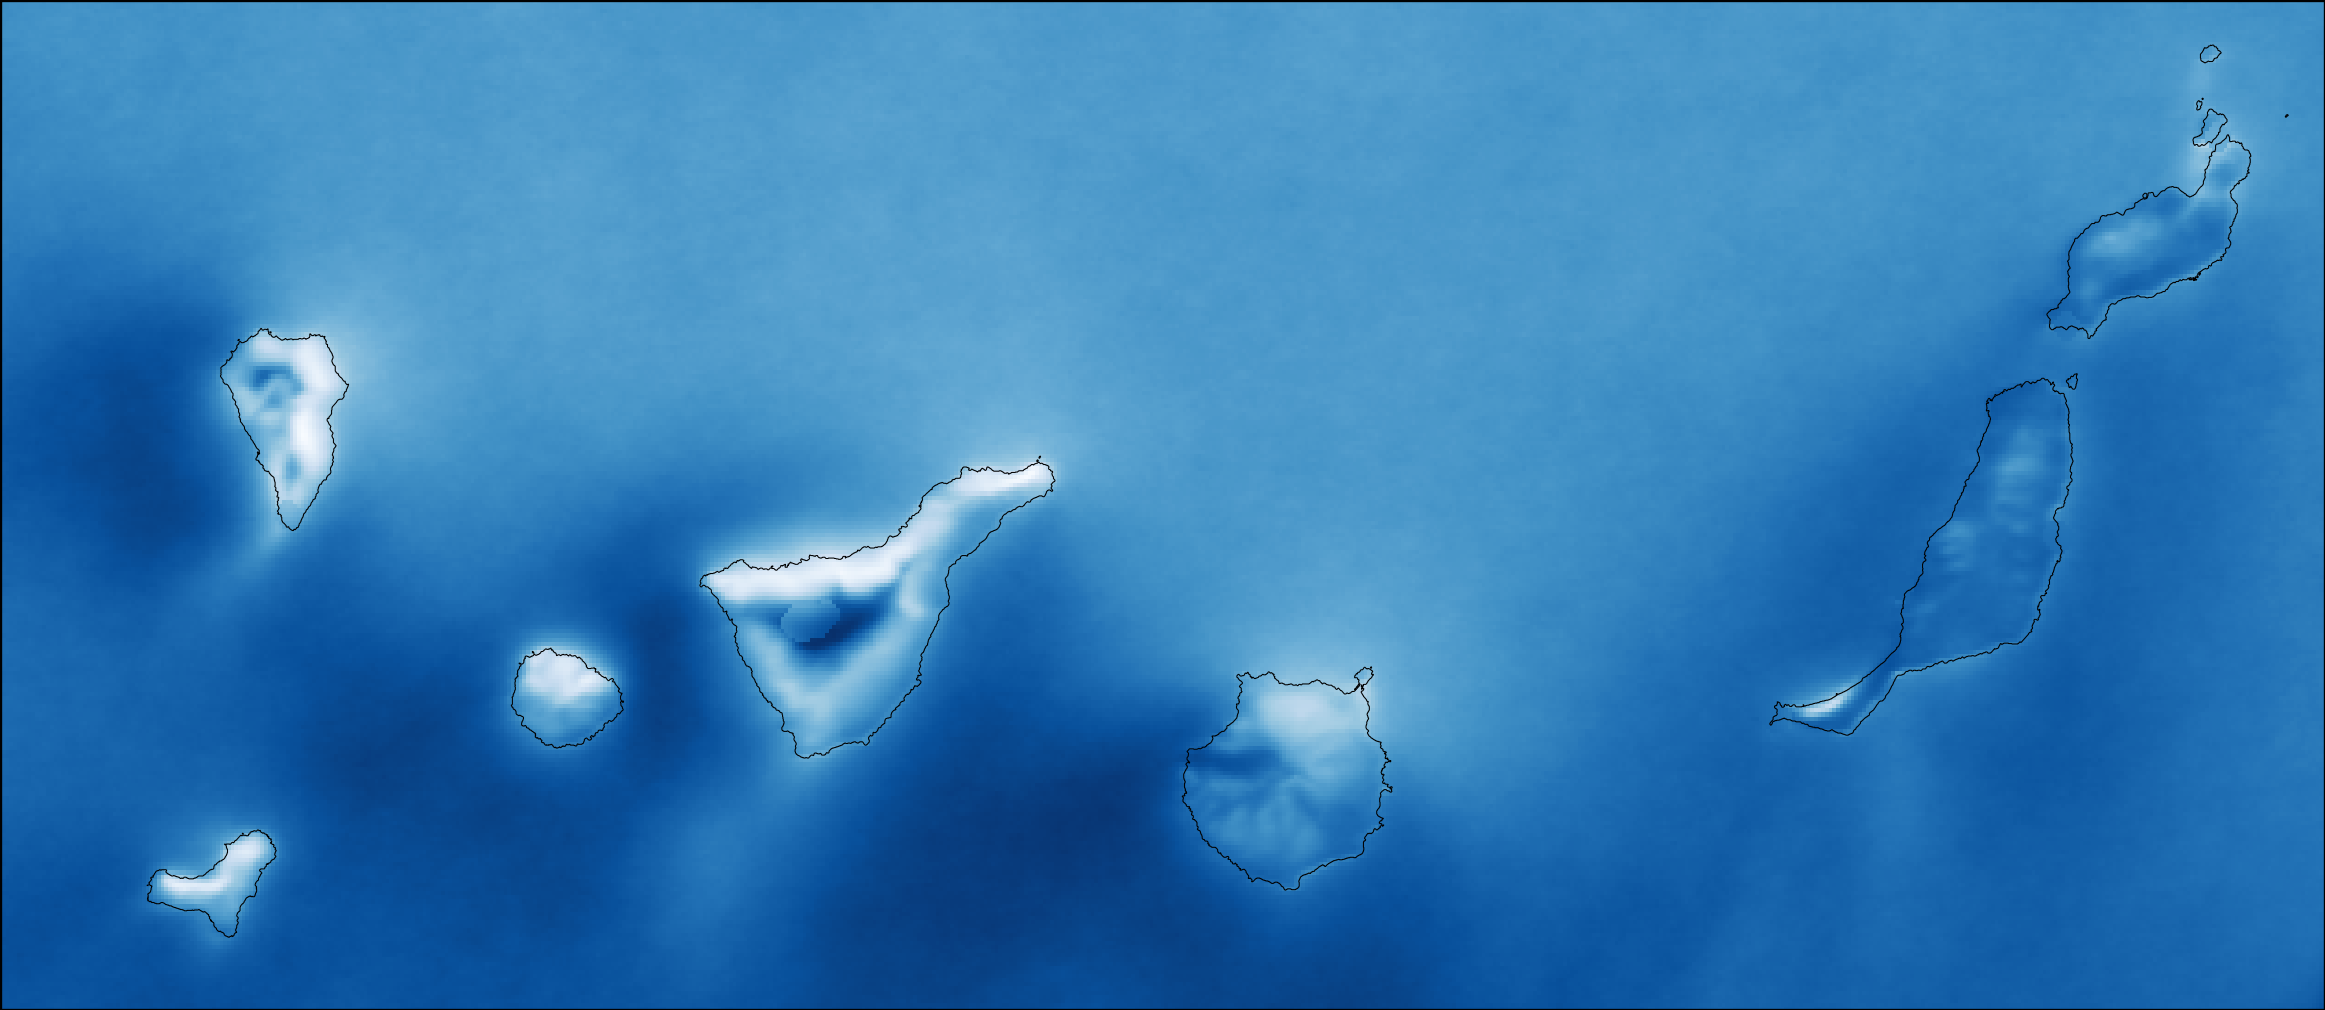

In [15]:
fig = plt.figure()
ax = plt.subplot(111, projection=IC.proj)

ax.set_extent(IC.bbox)

ax.pcolormesh(cloud.lon, cloud.lat, cloud.image, cmap=plt.cm.Blues_r,
          transform=hikinggc.data_crs, zorder=1, alpha=1)


ax.add_feature(coast, linewidth=.25, edgecolor="k")
#ax.imshow(hs2, origin='upper', extent=topography2.extent, 
#          transform=proj2, zorder=2, alpha=.2) # regrid_shape=3500


#shade = ax.pcolormesh(topography.lon, topography.lat, topogrey, cmap=plt.cm.gray,
#              transform=hikinggc.data_crs, zorder=4, alpha=.1)


#plot_coastline(ax, coastfile1)
#plot_coastline(ax, coastfile2)

# plt.savefig(os.path.join(hikinggc.figdir, "clouds_islands"))
plt.show()
plt.close()

### Gran Canaria only

In [28]:
cmap = plt.cm.gray
ls = LightSource(azdeg=315, altdeg=45)
rgb = ls.shade(topography.image, cmap=cmap, blend_mode='soft',
               vert_exag=0.05)

# Transform rgb to gray scale, so we can use pcolormesh (imshow failing)
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

topogrey = rgb2gray(rgb)
# Mask outside land
topogrey = np.ma.masked_where(topography.image == topography.image.min(), topogrey) 

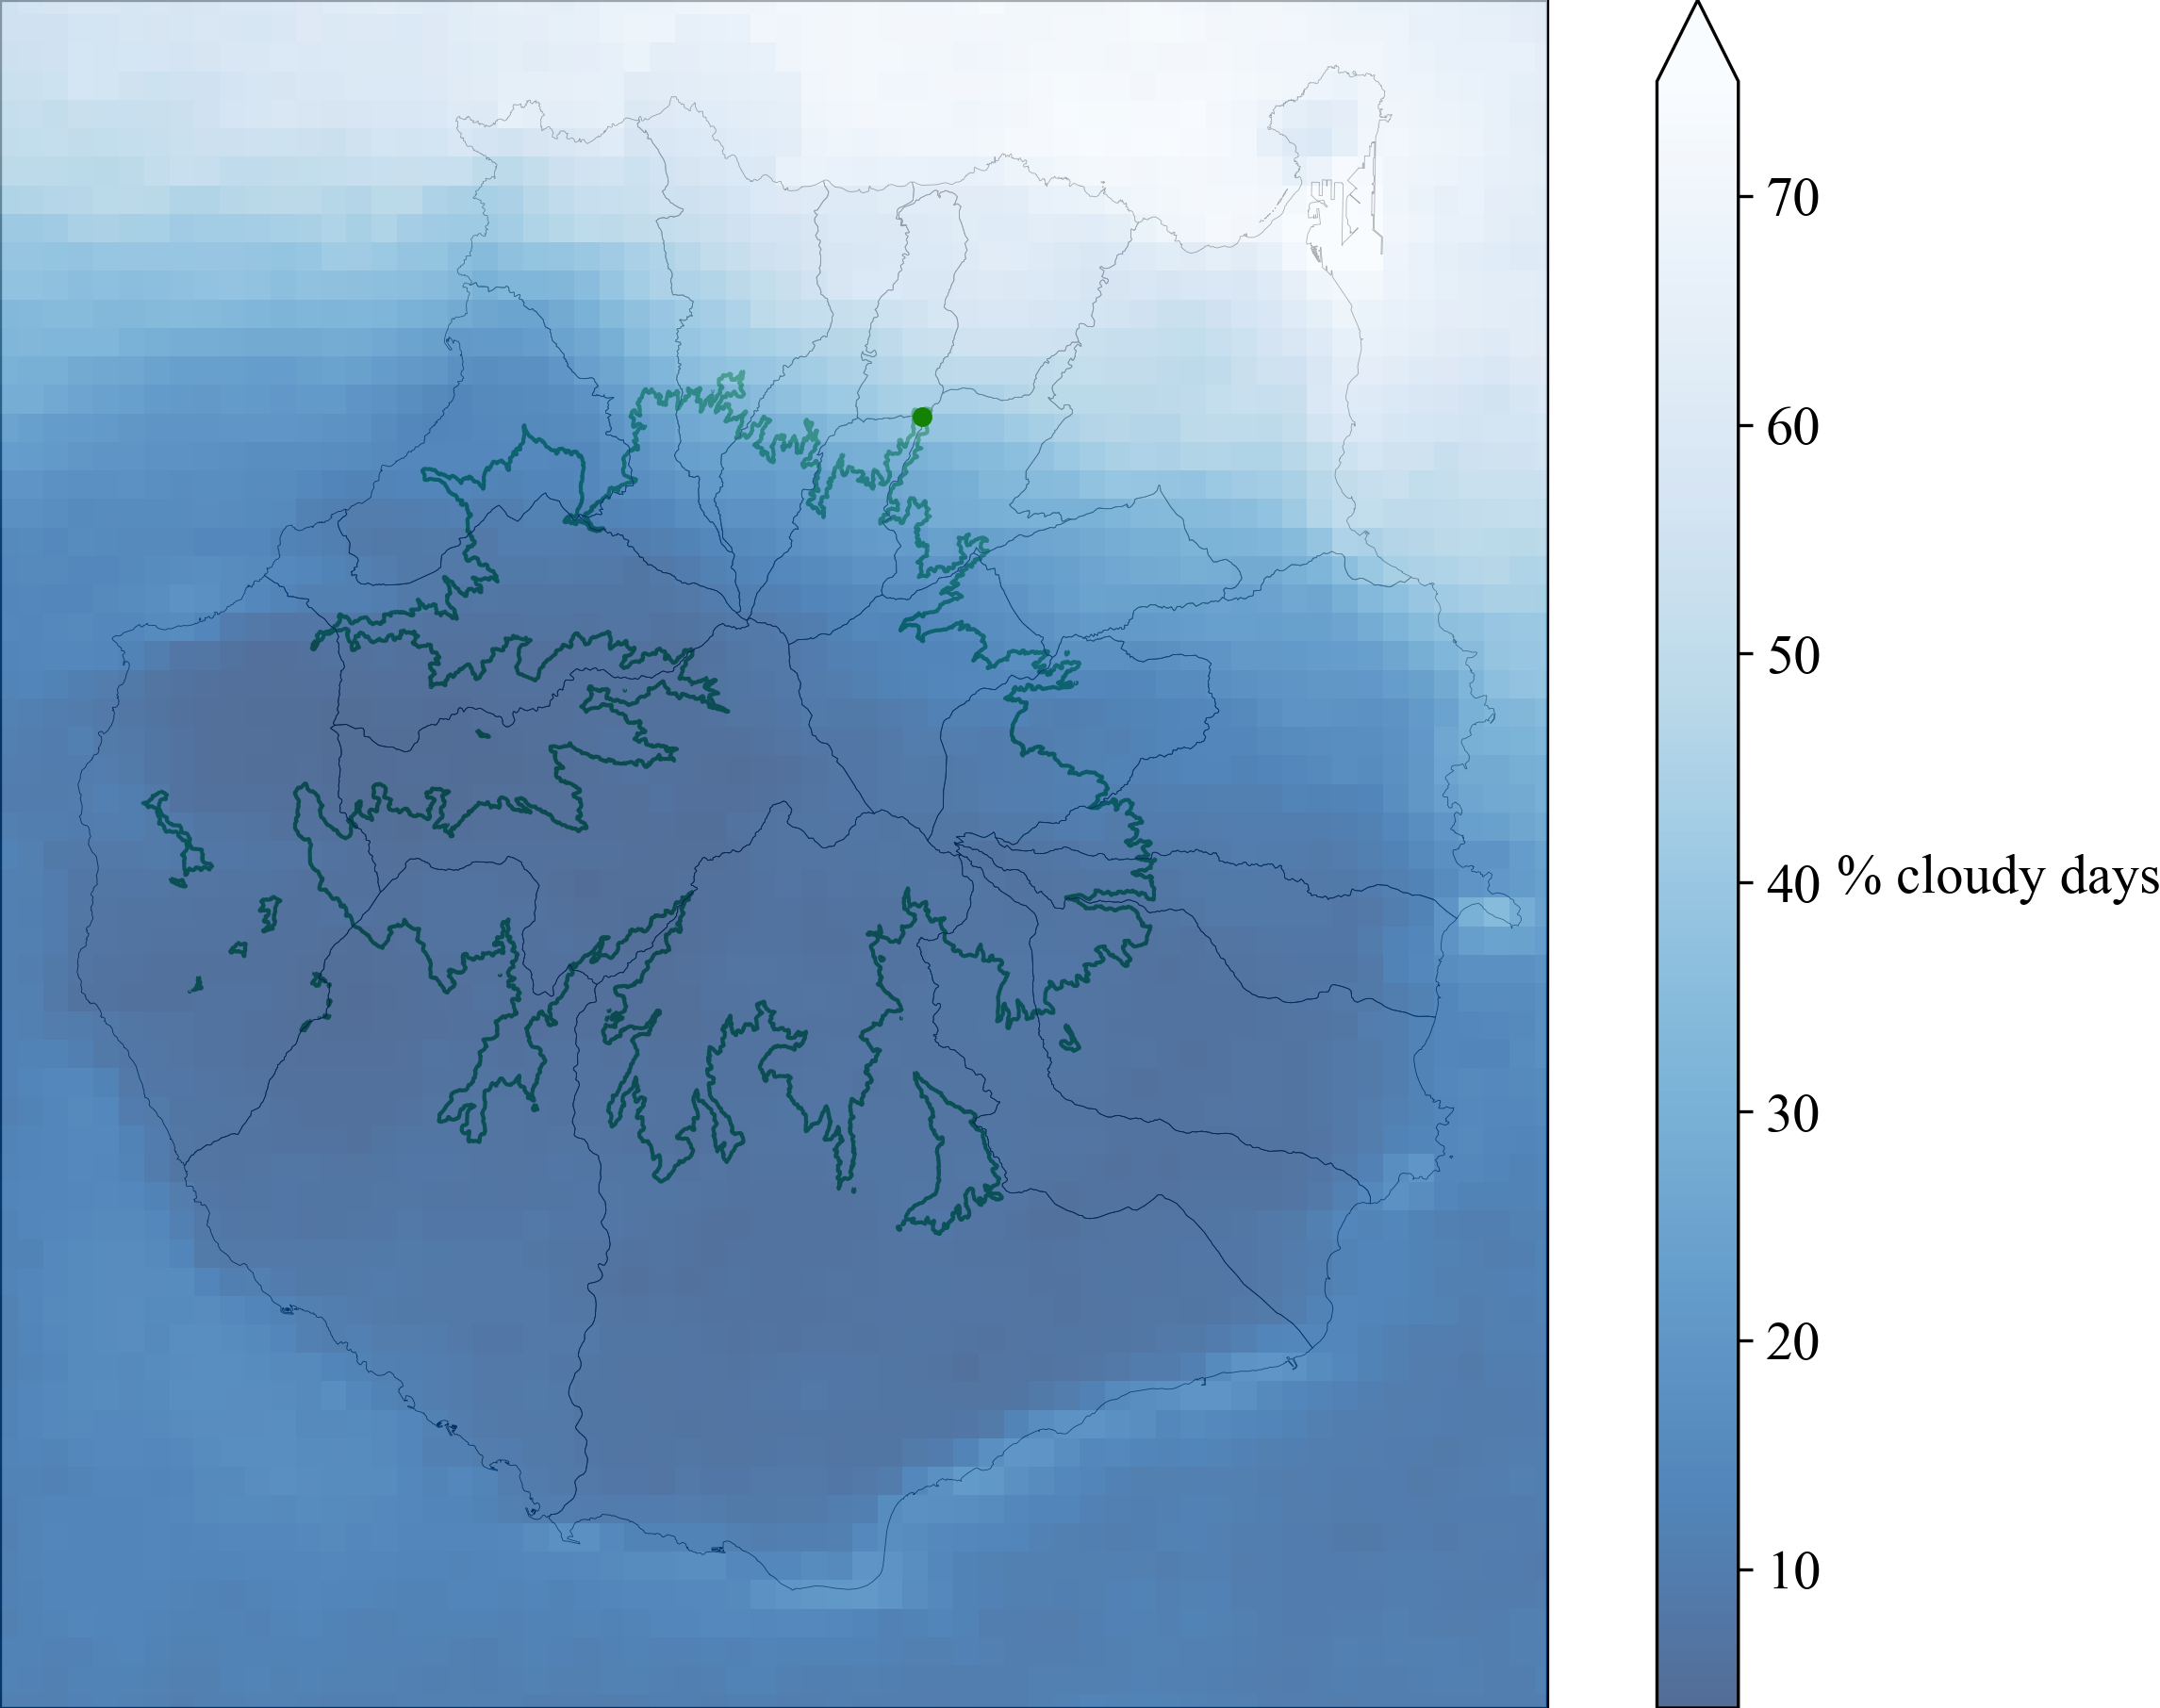

In [53]:
fig = plt.figure()
ax = plt.subplot(111, projection=IC.proj)

ax.set_extent(GC.bbox)
ax.contour(topography.lon[:-1], topography.lat, topography.image, [850.], transform=hikinggc.data_crs,
          colors=hikinggc.maingreen)
#shade = ax.pcolormesh(topography.lon, topography.lat, topogrey, cmap=plt.cm.gray,
#              transform=hikinggc.data_crs, zorder=3, alpha=1)

pcm = ax.pcolormesh(cloud.lon, cloud.lat, cloud.image * 0.01, cmap=plt.cm.Blues_r,
          transform=hikinggc.data_crs, zorder=4, alpha=.7, vmax=75)
ax.plot(-15.5561, 28.07833, "o", color=hikinggc.maingreen, transform=hikinggc.data_crs, zorder=7, ms=4)
cb = plt.colorbar(pcm, extend="max")
cb.set_label("% cloudy days", ha="left", rotation=0)

#ax.add_feature(coast, linewidth=.25, edgecolor="k")

for municipios in datamun["features"]:
    
    name = municipios['properties']['NAMEUNIT']

    # Get the coordinates
    coords = municipios['geometry']['coordinates']

    lonall, latall = [], []
    for c1 in coords:
        lon = []
        lat = []
        for c2 in c1:
            for c3 in c2:
                lon.append(c3[0])
                lat.append(c3[1])
        ax.plot(lon, lat, color='k', linewidth=.2, zorder=3, transform=hikinggc.data_crs)


plt.savefig(os.path.join(hikinggc.figdir, "clouds_gc_July.jpg"))
plt.show()
plt.close()

### Balearic islands

In [ ]:
domain = (1., 4.5, 38.5, 40.25)
cloud = hikinggc.Topography()
cloud.read_geotiff_domain(datafile2, domain)

In [ ]:
fig = plt.figure()
ax = plt.subplot(111, projection=ccrs.PlateCarree())
plt.pcolormesh(cloud.lon, cloud.lat, cloud.image, cmap=plt.cm.Blues_r,
          transform=hikinggc.data_crs)
   
ax.set_extent(domain)
plt.savefig(os.path.join(hikinggc.figdir, "clouds_balearic"))
plt.show()
plt.close()

In [ ]:
domain = (162.246, 179.473, -48.922, -32.990)
cloud = hikinggc.Topography()
cloud.read_geotiff_domain(datafile2, domain)

In [ ]:
fig = plt.figure()
ax = plt.subplot(111, projection=ccrs.PlateCarree())
plt.pcolormesh(cloud.lon, cloud.lat, cloud.image, cmap=plt.cm.Blues_r,
          transform=hikinggc.data_crs)
   
ax.set_extent(domain)
ax.coastlines(lw=.25)
# plt.savefig(os.path.join(hikinggc.figdir, "clouds_can"))
plt.show()
plt.close()